## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

# Подгружаем библеотеку для чтения субтитров
import pysrt
# Подгружаем библеотеку для получения списка специальных символов
import string
# Подгружаем библеотеки для выделения слов из текста
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Подгружаем библиотеку для преобразования слов в их исходное значение (к корню)
from nltk.stem import WordNetLemmatizer
# Подгружаем библиотеку для разделения выборки на обучающую и тестовую
from sklearn.model_selection import train_test_split

# Подгрузим модель CatBoost для разнообразия
from catboost import CatBoostClassifier
from catboost import cv, Pool

# Метрики для оценки качества модели
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Для расчета меры близости между текстами добавим метрики расстояний
from scipy.spatial.distance import cityblock, euclidean, cosine

# Для построения диаграмм подгрузим данную библиетеку
from matplotlib import pyplot as plt

# Добавим библиотеку для итераций по словарям
import operator

# Добавим библиотеку случаностей
import random

# Добавим библиотеку для подсчета количества вхождений элемента в список
from collections import Counter

# Подгружаем библиотеки для получения списка файлов из папки
from os import listdir
from os.path import isfile, join

## Функции используемые в проекте

### Свод базовых функций

In [2]:
# 1
# Функция для загрузки данных, хранящих информацию об уровнях английского
def func_load(file):
    
    # загрузим данные
    try:
        data_levels = pd.read_excel(file)
        
    except:
        print('Проблема с данными, попробуйте снова.')
    
    return data_levels

# 2
# Функция для формирования общего массива слов из фремов с уровнями английского
def united_words(*args):
    
    united = []
    
    # запустим обработку фреймов с учетом, того что их может быть много
    for arg in args:        
        for column in arg.columns:
            # пройдемся циклом по всем элементам из столбцов до появления пропусков
            for word in (np.array(arg[arg[column].isna() == False][column])):
                united.append(word.strip())

    return united

# 3
# Функция аналогичная вышестоящей, однако здесь мы объдиним фреймы в один, сохранив разделение по классам.
def class_united(*frames):
    
    # объявим конечный фрейм
    result_frame = pd.DataFrame()
    
    # распакуем фремы
    arr_frames = []
    
    for frame in frames:
        arr_frames.append(frame)
        
    # объединим в один фрейм
    result_frame = pd.concat(arr_frames)
    
    # обновим индексацию
    result_frame = result_frame.reset_index(drop=True)
    
    return result_frame
    
    
# 4
# Функция для удаления лишних символов
def remove_symbol(text, symbols_to_delete):
    for symbol in symbols_to_delete:
        text = text.replace(str(symbol), '')
    return text

# 5
# Функция для разделения текста по словам с удалением стоп-слов
def transform_text(text):
    
    # разделяем текст по словам (токенам)
    word_tokens = word_tokenize(text)
    # убираем стоп слова из текста
    word_tokens = [word for word in word_tokens if word not in STOP_WORDS]
    # приводим слова к изначальной форме
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    
    return lemmas

# 6
# Функция для чтения субтитров и преобразования их в удобный для обработки вид
def subs_transform(file):
    
    # чтение субтитров из файла
    subs = pysrt.open(file, encoding='iso-8859-1')

    # объединим субтитры в один единый текст
    subs_union = "".join([str(sub) for sub in subs])

    # уберём все лишние символы, такие как цифры и специальные символы вместе со знаком перевода строки
    subs_union = remove_symbol(subs_union, DIGITS + PUNCTUATIONS)

    # переведём всё в нижний регистр
    subs_union = subs_union.lower()
    
    # преобразуем текст субтитров в список слов
    subs_union = transform_text(subs_union)
    
    return subs_union

# 7
# Функция для масштабирования частоты появления слов
def freq_word_scal(subs, freq_word_subs):
        '''
        Данная функция необходима, для того избавится от проблемы больших и маленьких текстов.
        Имеется ввиду следующее, если фильм длинной около 3 часов, то количество слов в субтитрах 
        будет существенно больше чем в фильме длинной час. Для этого, будем находить долю частоты
        появления конкретного слова от общего числа слов в тексте. 
        '''
        # найдём общее количество слов в субтитрах
        count_words = len(subs)
        
        # запустим цикл по словарю частот слов, получая доли от общего числа слов в субтитрах
        for key in freq_word_subs.keys():
            try:
                freq_word_subs[key] = freq_word_subs[key] / count_words
            except:
                freq_word_subs[key] = 0
            
        return freq_word_subs
    
# 8
# Функция для подсчета частоты повторения слов
def frequency_word(list_word_from_text, list_word_by_levels):
    
    # объявим словарь, который будет собирать частоты появления слов
    freq_words = {}
    
    # запускаем цикл по словам из списка уникальных значений, на основе которых, 
    # выстраиваются уровни владения языком (уровневый список)
    for level_word in list_word_by_levels:
        # для удобства, вначале будем присваивать ноль для базового значения частот слов
        freq_words[level_word] = 0
        # запускаем цикл по словам из списка текста
        for text_word in list_word_from_text:
            # подсчёт частот производится на основе равенства слов из уровнего списка со словами из текста
            if(level_word == text_word):
                freq_words[level_word] += 1
                
    # произведём масштабирование частот слов
    freq_words = freq_word_scal(list_word_from_text, freq_words)
                
    return freq_words

# 9
# Функция для получения списка файлов в заданной папке
def func_list_files(folder_path):
    
    # получим список файлов
    list_files = [folder_path + f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    
    return list_files

# 10
# Функция, осуществляющая разметку текстов из заданной папки, c получением общего фрейма данных
def text_markup(folder_path, combined_unique_words):
    
    # получим список файлов для разметки
    list_files = func_list_files(folder_path)
    
    # объявим матрицу частот слов, переменную для хранения субтитров,
    # массив, содержащий текущий набор частот слов и результирующий фрейм данных
    matrix_values = [] 
    subs = ''
    freq_words = []
    result = pd.DataFrame()
    
    # запустим обработку всех текстовых файлов в заданном каталоге
    for file in list_files:
        
        # обработка текущего файла субтитров
        subs = subs_transform(file)
        # получим массив значений частот слов
        freq_words = [val for val in frequency_word(subs, combined_unique_words).values()]
        
        # добавим получившуюся вектор-строку в матрицу значений
        matrix_values.append(freq_words)
        
    # сформируем обобщённый фрейм данных, который будет содержать частоты слов для каждого фильма 
    result = pd.DataFrame(data=matrix_values, columns=combined_unique_words)
    
    return result

# 11
# Расчёт меры близости строк
def strings_dist(row, *args):
    # объявим массив, который будет содержать аргументы функции
    args_values = []
    for arg in args:
        args_values.append(arg)
        
    # зададим словарь функций
    func_dict = {
        'cityblock': cityblock(row, args_values[0]),
        'euclidean': euclidean(row, args_values[0]),
        'cosine': cosine(row, args_values[0])    
    }
    
    # вычислим близость строк
    for key in func_dict.keys():
        if(key == args_values[1]):
            return func_dict[key]

### Функции для разметки новых данных

In [3]:
# 1
# Слегка изменённая функция для расчёта расстояний между строками
def str_distance(vector1=None, vector2=None, method=None):
    
    # зададим словарь функций
    func_dict = {
        'cityblock': cityblock(vector1, vector2),
        'euclidean': euclidean(vector1, vector2),
        'cosine': cosine(vector1, vector2)    
    }
    
    # вычислим близость строк
    try:
        for key in func_dict.keys():
            if(key == method):
                return func_dict[key]
    except:
        print("Пожалуйста задайте все необходимые параметры для вычислений.")
        
# 2
# Функция для определения сложности текста на основе принадлежности топ слов к тому или иному уровню сложности
def level_top_words(vector, levels, top=None):
    """
    Суть данной функции в том, что мы берём топ N слов из текста (определяем при запуске функции) 
    и сверяем со словами, которые есть в уровнях языка.
    В каком уровне получилось больше вхождений слов из текста, значит тот уровень и выбираем.
    """
    
    # зададим переменную для хранения получившегося уровня сложности
    result_lvl = None
    
    # избавимся от слов, которых в тексте не было
    zero = pd.Series([0])
    vector = vector[~np.isin(vector, zero)]
    
    # выделяем заданный топ слов
    if(top < len(vector)):
        top_words = vector.sort_values(ascending=False).head(top)
    else:
        top_words = vector.sort_values(ascending=False)
    
    # объявим словарь, в который будем помещать подсчитанное количество слов
    levels_counts = {}
    
    # запускаем цикл по уровням сложности
    for lvl in levels.columns:
        count = 0
        for word in top_words.index:
            if (word in levels[lvl].values):
                count += 1
                
        # передаём значения в словарь
        levels_counts[lvl] = count
    
    # определим уровень с самым высоким числом вхождения слов
    result_lvl = max(levels_counts.items(), key=operator.itemgetter(1))[0]
    
    return result_lvl

# 3
# Функция для определения сложности текста на основе расчета расстояний близости строк
def level_lang_distance(vector, mean_in_class):
    
    # объявим словарь для хранения расстояний
    level_dict = {}
    
    # объявим массив для хранения результатов расчетов близостей
    result = []    
       
    # запускаем цикл по методам расчета близости строк
    for method in ['cityblock', 'euclidean', 'cosine']:
        
        # объявляем массив для хранения расстоний
        arr_dist = []
        
        # запускаем цикл для расчета близости по массиву, содержащему усреднённые значения для каждой категории
        classes = mean_in_class.columns
        for clas in classes:
            arr_dist.append(str_distance(vector, mean_in_class[clas], method))
        
        # определим минимальное значение расстояния, и заодно проверим нет ли одинаковых значений       
        min_value = min(arr_dist)        
        indices = [index for index, val in enumerate(arr_dist) if val == min_value]
        # проверка на количество похожих значений
        if(len(indices) == 1):
            result.append(classes[indices][0])
        else:
            # так как одинаковые значения расстояний редкое событие, но обратотать его надо,
            # то обработаем его хотябы случайным выбором.
            result.append(classes[random.choice(indices)][0])
            
    return result

# 4
# Функция для расчета принадлежности к классу на основе предсказаний модели обученной на исходных данных
def class_on_model(vector, model):
    
    return model.predict(vector)[0]

# 5
# Решающая функция для определения принадлежности текста к уровню сложности языка
def solve_lvl_lang(vector, frames_united_lvl):
    """
    Данная функция будет определящей в том случае если, "ансамбль из слабых классификаторов" не сможет самостоятельно 
    определить принадлежность текста к тому или иному уровню сложности.
    В данной функции будем определять принадлежность текста к уровню сложности на основе всех встречаемых слов в тексте.
    Сравнивать будем с фреймом данных, в котором хранятся все возможные слова из британского и американского фремов.
    """
    level_lang = level_top_words(vector, frames_united_lvl, top=len(vector))
    
    return level_lang    

# 6
# Функция для определения конечной сложности текста
def ensemble_classifiers(vector, british, americ, mean_in_class, model):
    """
    Данная функция представляет собой ансамбль из слабых классификаторов.
    Исходя из того, что у нас нет возможности произвести "грамотную" разметку данных,
    то делать ее будет исходя из работы нескольких классификаторов, где "голосованием"
    будем определять, к какому уровню сложности стоит отнести тот или иной текст.
    """
    
    # зададим массив, который будет содержать результаты работы разных классификаторов
    result_class = []
    
    # уберём лишнее поле с названием
    vector = pd.Series(vector.drop('Movie'))
    
    # найдём общий фрейм по уровням языка
    #frames_united_lvl = class_united(british, americ)
    
    # получим уровни сложности относительно разновидностей языка (британский и американский)
    # из-за наличия множества слов на уровнях A будем брать, только топ 20 самых встречаемых слов в тексте
    result_class.append(level_top_words(vector, british, top=20))
    result_class.append(level_top_words(vector, americ, top=20))
    
    # получим уровни сложности на основе близостей текста к усреднённым значениям по каждому классу
    result_class.extend(level_lang_distance(vector, mean_in_class))
    
    # получим уровень сложности на основе предсказаний модели обученной на исходных данных
    result_class.append(class_on_model(vector, model))
    
    # вычислим сколько было вхождений полученных классов в массиве
    result = max(Counter(result_class).items(), key=operator.itemgetter(1))[0]
    
    return result

## Перечень используемых в проекте констант

In [4]:
# Цифры
DIGITS = ''.join([str(digit) for digit in range(10)])

# Знаки препинания и символ перевода строки
PUNCTUATIONS = string.punctuation + '\n'

# Выделяем список стоп-слов
STOP_WORDS = set(stopwords.words('english'))

## Загрузка данных

In [5]:
# Из-за того, что начальный уровень А1 по содержит большую часть слов, то использовать классификатор принадлежности
# на основе уровней сложности по сути становится невозможно. Из-за этого уберём данный класс из выборки

# загрузим данные по уровням для английского языка 
british_levels = func_load('British_levels.xlsx')
british_levels = british_levels.drop('A1', axis=1)
display(british_levels.head(5))

# загрузим данные по уровням для американского языка 
americ_levels = func_load('American_levels.xlsx')
americ_levels = americ_levels.drop('A1', axis=1)
display(americ_levels.head(5))

# загрузим файл, в котором хранится информация о сложности фильмов
movies_levels = func_load('movies_labels.xlsx')
display(movies_levels.head(5))

# загрузим обученную модель CatBoost
CatBoost_model = CatBoostClassifier()
CatBoost_model.load_model('model_multiclass')

# загрузим уже размеченный фрейм данных, содержащий масштабированные частоты повторения слов в субтитрах
data = func_load('origin_data.xlsx')
display(data.head(5))

,A2,B1,B2,C1
0,ability,academic,absorb,acceptance
1,able,access,abstract,accessible
2,abroad,accommodation,accent,accomplishment
3,accept,account,accidentally,accordance
4,accident,achievement,accommodate,accordingly


,A2,B1,B2,C1
0,ability,absolutely,absorb,abolish
1,able,academic,abstract,abortion
2,accept,access,accent,absence
3,accident,account,accidentally,absent
4,according to,achievement,accommodate,absurd


,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2


,ability,able,abroad,accept,accident,according to,achieve,act,active,actually,...,rumor,setup,skeptical,sophomore,superintendent,tumor,unconstitutional,Movie,id,Level
0,0.0,0.001036,0.0,0.000345,0.001036,0,0.0,0.000000,0.000000,0.000691,...,0.000000,0.000000,0,0.000000,0,0.0,0,10_Cloverfield_lane(2016),0,B1
1,0.0,0.000235,0.0,0.000235,0.000000,0,0.0,0.000471,0.000000,0.001883,...,0.000471,0.000235,0,0.000471,0,0.0,0,10_things_I_hate_about_you(1999),1,B1
2,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0.000000,0,0.0,0,Aladdin(1992),4,A2
3,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000225,...,0.000000,0.000000,0,0.000000,0,0.0,0,All_dogs_go_to_heaven(1989),5,A2
4,0.0,0.000467,0.0,0.000234,0.000234,0,0.0,0.000234,0.000234,0.000935,...,0.000000,0.000000,0,0.000000,0,0.0,0,AmericanBeauty1999.BRRip,118,B1


## Формирование фрейма данных с частотами слов

In [6]:
# Соберём единый массив, который будет содержать все уникальные слова
united = pd.Series(united_words(british_levels, americ_levels)).unique()

**Сохраним получившийся фрейм данных в файл, чтобы в будущем его можно было быстрее использовать и не производить расчёт каждый раз.**

## Подготовка данных к обучению моделей

In [7]:
# разделим данные на признаки и целевые значения
features = data.drop(['Movie', 'id', 'Level'], axis=1)
target = data['Level']

# разделим на выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size=0.2, random_state=12345)

## Разработка модели "CatBoost"

Для того, чтобы каждый раз не искать лучшую модель, а также не обучать ее, произведём обучение один раз и сохраним в файл.

***Значение параметра "learning rate" можно оставить на уровне 0.009.***

## Проверка лучшей модели

**Сохраним обученную модель.**

Теперь модель сохранена и можем перестать обучать модель при каждом запуске программы.

## Дополнительное изучение данных

Посмотрим на наши данные разбитые на категории.

In [8]:
# Уберём из данных лишние поля
cut_data = data.drop(['Movie', 'id'], axis=1)
display(cut_data.head(5))

,ability,able,abroad,accept,accident,according to,achieve,act,active,actually,...,rookie,roster,rumor,setup,skeptical,sophomore,superintendent,tumor,unconstitutional,Level
0,0.0,0.001036,0.0,0.000345,0.001036,0,0.0,0.000000,0.000000,0.000691,...,0.0,0.0,0.000000,0.000000,0,0.000000,0,0.0,0,B1
1,0.0,0.000235,0.0,0.000235,0.000000,0,0.0,0.000471,0.000000,0.001883,...,0.0,0.0,0.000471,0.000235,0,0.000471,0,0.0,0,B1
2,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0,0.000000,0,0.0,0,A2
3,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.000000,0.000000,0.000225,...,0.0,0.0,0.000000,0.000000,0,0.000000,0,0.0,0,A2
4,0.0,0.000467,0.0,0.000234,0.000234,0,0.0,0.000234,0.000234,0.000935,...,0.0,0.0,0.000000,0.000000,0,0.000000,0,0.0,0,B1


**Вычислим усреднённые значения по категориям.**

In [9]:
# объявим массив, который будет содержать усреднённые значения для каждой категории
mean_cat = []
# разделим данные на срезы по категориям и расчитаем усреднённые значения по каждому полю
for cat in cut_data['Level'].unique():
    mean_cat.append(cut_data.query('Level == @cat').mean())

Расстояния вычислены методом cityblock


E:\progy\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


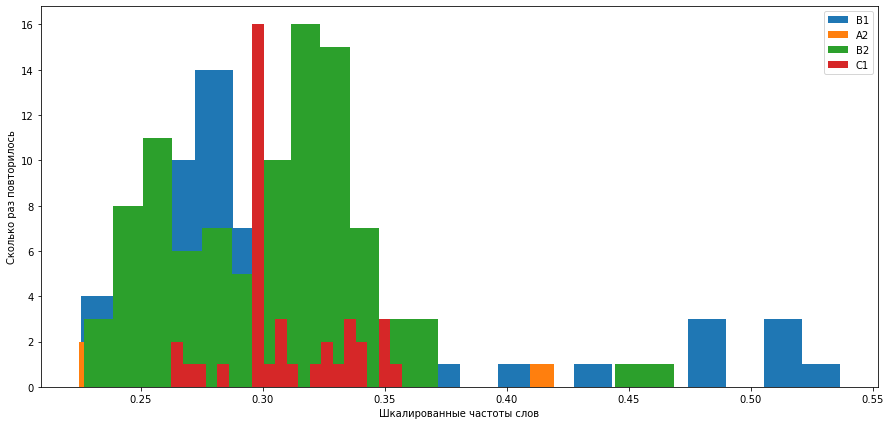

Расстояния вычислены методом euclidean


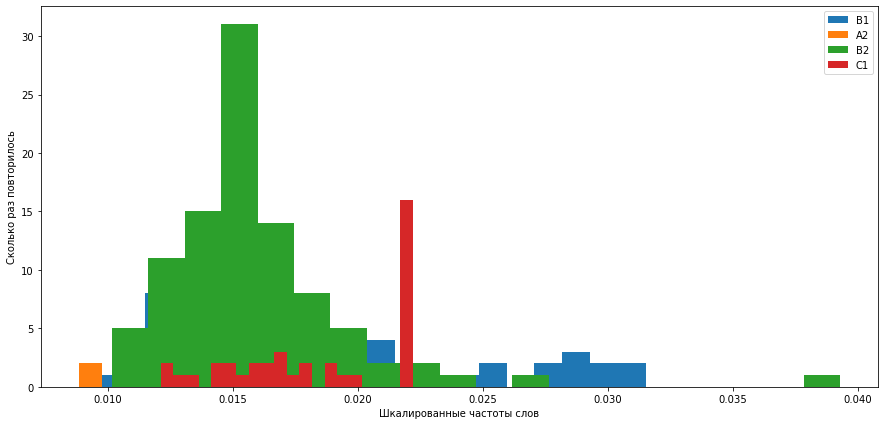

Расстояния вычислены методом cosine


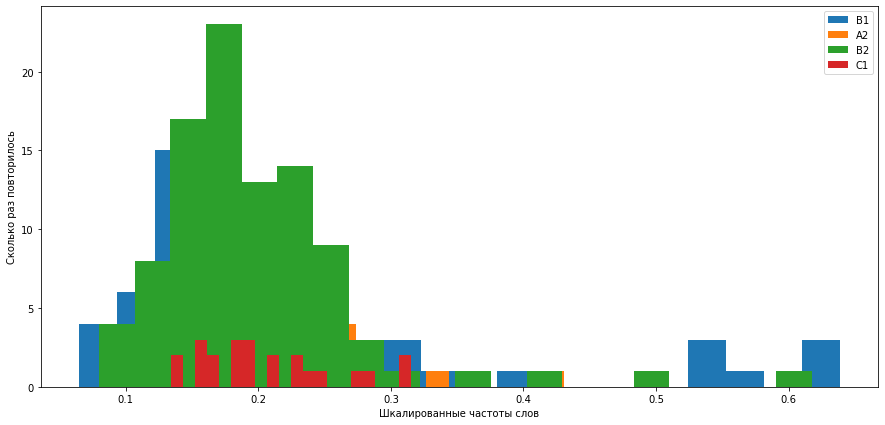

In [10]:
# Посмотрим на диаграммах, как распределяются расстояния по категориям относительно центров этих категорий
for distance in ['cityblock', 'euclidean', 'cosine']:
    print('Расстояния вычислены методом', distance)
    # зададим размер диаграммы
    plt.figure(figsize=(15, 7))
    # пройдёмся по уровням сложности отдельно
    for lvl in cut_data['Level'].unique():
        df = cut_data.query('Level == @lvl').drop('Level', axis=1) # срез данных по уровню
        dist = df.apply(strings_dist, args=(mean_cat[0].values, distance), axis=1) # расчёт расстояний
        # построение диграмм
        plt.hist(dist, bins=20)        
        plt.xlabel('Шкалированные частоты слов')
        plt.ylabel('Сколько раз повторилось')
    # добавим легенду на диграммы
    plt.legend(cut_data['Level'].unique())
    # сделаем так, чтобы все уровни показались на одной диаграмме
    plt.show()

In [11]:
# обернём перменную с усреднёнными значениями в фрейм данных
mean_cat = pd.DataFrame(data=np.array(mean_cat).T, columns=cut_data['Level'].unique())
display(mean_cat)

,B1,A2,B2,C1
0,0.000027,0.000013,0.000038,0.000027
1,0.000345,0.000192,0.000222,0.000125
2,0.000005,0.000007,0.000011,0.000014
3,0.000116,0.000103,0.000216,0.000164
4,0.000111,0.000059,0.000140,0.000014
...,...,...,...,...
4323,0.000000,0.000000,0.000000,0.000000
4324,0.000008,0.000000,0.000009,0.000000
4325,0.000000,0.000000,0.000000,0.000000
4326,0.000000,0.000005,0.000004,0.000000


***Как можем видеть, по данным диаграммам, все способы расчета дают разные значения расстояний. Однако, можем наблюдать, что большая часть значений расстояний лежит в левой части диаграмм. Из этого можно сделать вывод, что значения лежачие справа скорее всего точно будут относится к той или иной сложности языка. Исходя из это можем построить классификатор, который поможет сделать разметку для новых текстов.***

## Обработка новых субтитров

**Получим фрейм данных для новых субтитров.**